In [1]:
import pandas as pd

train = pd.read_csv('./datasets/train.csv')
test = pd.read_csv('./datasets/test.csv')

In [2]:
train = train[train['label']!=2]
test = test[test['label']!=2]

In [3]:
from sklearn.model_selection import train_test_split

train, valid = train_test_split(train, stratify=train.label, test_size=0.2, random_state=42)

In [4]:
train_tweet = train[['tweet','username','label']]
test_tweet = test[['tweet','username','label']]
valid_tweet = valid[['tweet','username','label']]

In [5]:
train_tweet = train[['tweet','username','label']].groupby(['username','label'])['tweet'].apply(list).reset_index(name='text')
valid_tweet = valid[['tweet','username','label']].groupby(['username','label'])['tweet'].apply(list).reset_index(name='text')
test_tweet = test[['tweet','username','label']].groupby(['username','label'])['tweet'].apply(list).reset_index(name='text')

In [6]:
train_tweet = train_tweet.reset_index()
test_tweet = test_tweet.reset_index()
valid_tweet = valid_tweet.reset_index()

In [7]:
train = train_tweet
test = test_tweet
valid = valid_tweet

In [8]:
import csv
import pandas as pd 
import numpy as np 
from collections import defaultdict
import re
import sys
from sklearn.model_selection import train_test_split
import datetime
import matplotlib.pyplot as plt
import time
import numpy as np
from pprint import pprint

import spacy  # For preprocessing
import nltk
import string
from nltk.corpus import stopwords
import preprocessor as p  #pip install tweet-preprocessor
import logging  # Setting up the loggings to monitor gensim
from nltk.stem import WordNetLemmatizer
from string import punctuation as punc

import gensim
import gensim.corpora as corpora
#from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import gensim.models as gsm
from gensim.test.utils import datapath

import regex
# import emoji #pip install emoji --upgrade
# Internal dependencies
# import word_emoji2vec as we2v
#from word_emoji2vec import Word_Emoji2Vec

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd
# import torchvision.transforms as transforms
from torch.autograd import Variable

####BERT

from transformers import BertTokenizer, BertModel

# OPTIONAL: if you want to have more information on what's happening, activate the logger as follows
import logging
logging.basicConfig(level=logging.INFO)

# Load pre-trained model tokenizer (vocabulary)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [9]:
import torch
# torch.cuda.empty_cache() 
# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    #device = torch.device("cuda") # select the zeroth GPU with this line: gpu = 0
    #device = torch.cuda.set_device(1)  #wrong provide device = None  
    device = torch.device(0) #(use cuda device 1) for gpu = 1
    torch.cuda.set_device(device)
    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name())

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 3 GPU(s) available.
We will use the GPU: GeForce RTX 2080 Ti


In [10]:
print ('Current cuda device ', device) # check

Current cuda device  cuda:0


In [11]:
device = torch.cuda.current_device()
device

0

In [12]:
!nvidia-smi

Sat Sep 25 01:21:46 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.59       Driver Version: 440.59       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:1A:00.0 Off |                  N/A |
| 46%   69C    P2    90W / 250W |   3926MiB / 11019MiB |     19%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  Off  | 00000000:67:00.0 Off |                  N/A |
| 53%   83C    P2   112W / 250W |  10556MiB / 11019MiB |     33%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [13]:
# import os

# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [14]:
###### text preprocessing #########

def remove_string_noise(input_str):
    input_str = re.sub(r"http\S+", "", input_str)
    punctuation_noise ="!\"$%&'#()*+,-./:;<=>?@[\]^_`{|}~" #print string.punctuation 
    special_noise = ""

    all_noise = punctuation_noise + special_noise

    for c in all_noise:
        if c in input_str:
            input_str = input_str.replace(c, " ")#replace with space
    fresh_str = ' '.join(input_str.split())
    return fresh_str

def clean_tweets(tweet):
    wordnet_lemmatizer = WordNetLemmatizer()
    sw = set(stopwords.words('english'))
    operators = set(('no', 'not', 'nor', 'none'))
    stop_words = set(sw) - operators
    stop_words.update([ 'amp', 'rt'])  ###as we are using set so we used .update....otherwise .extends
    
    word_tokens = nltk.word_tokenize(tweet)
    filtered_tweet = []
    for w in word_tokens:
        #if w not in stop_words and w not in emoticons:
        if w not in stop_words:
            filtered_tweet.append(w)
    lemmatized_tweet = []
    for word in filtered_tweet:
        lemmatized_tweet.append(wordnet_lemmatizer.lemmatize(word, pos="v"))
    return ' '.join(lemmatized_tweet)
    
def pre_processing_tweets (df):    
    clean_text = []

    for i in df:
        clean_text.append(p.clean(str(i)))#python 3
    fresh_text1 = []
    for i in range (0, df.shape[0]):
        fresh_text1.append(remove_string_noise(clean_text[i]))
    
    filtered_tweet = []
    for i in range (0, len(fresh_text1)):
        filtered_tweet.append(clean_tweets(fresh_text1[i].lower()))
    
    return filtered_tweet

In [15]:
sentences_train = pre_processing_tweets(train.text)
sentences_valid = pre_processing_tweets(valid.text)
sentences_test = pre_processing_tweets(test.text)

In [16]:
sentences_train = np.array(sentences_train)
labels_train = train.label.values
print(type(sentences_train))

sentences_valid = np.array(sentences_valid)
labels_valid = valid.label.values
print(type(sentences_valid))

sentences_test = np.array(sentences_test)
labels_test = test.label.values
print(type(sentences_test))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [17]:
import torch
from transformers import LongformerModel, LongformerTokenizer
tokenizer = LongformerTokenizer.from_pretrained('allenai/longformer-base-4096', do_lower_case=True)
model = LongformerModel.from_pretrained('allenai/longformer-base-4096', gradient_checkpointing=True)

Some weights of the model checkpoint at allenai/longformer-base-4096 were not used when initializing LongformerModel: ['lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing LongformerModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LongformerModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [18]:
SAMPLE_TEXT = ' '.join(['Hello world! '] * 1000)  # long input document
input_ids = torch.tensor(tokenizer.encode(SAMPLE_TEXT)).unsqueeze(0)  # batch of size 1

# Attention mask values -- 0: no attention, 1: local attention, 2: global attention
attention_mask = torch.ones(input_ids.shape, dtype=torch.long, device=input_ids.device) # initialize to local attention
global_attention_mask = torch.zeros(input_ids.shape, dtype=torch.long, device=input_ids.device) # initialize to global attention to be deactivated for all tokens
global_attention_mask[:, [1, 4, 21,]] = 1  
outputs = model(input_ids, attention_mask=attention_mask, global_attention_mask=global_attention_mask)

In [19]:
sequence_output = outputs[0] #last_hidden_state
pooled_output = outputs[1] #pooler_output

In [20]:
# print(sequence_output)
# print(pooled_output)

In [21]:
# Get the lists of sentences and their labels.

sentences_train_twt = np.array(sentences_train)
# sentences_train_loc = np.array(df_train.location.values)
# sentences_train_des = np.array(df_train.description.values)
labels_train = torch.tensor(train.label.values)
#print(type(sentences_train_loc))


sentences_valid_twt = np.array(sentences_valid)
# sentences_valid_loc = np.array(df_valid.location.values)
# sentences_valid_des = np.array(df_valid.description.values)
labels_valid = torch.tensor(valid.label.values)
#print(type(sentences_valid_loc))


sentences_test_twt = np.array(sentences_test)
# sentences_test_loc = np.array(df_test.location.values)
# sentences_test_des = np.array(df_test.description.values)
labels_test = torch.tensor(test.label.values)
#print(type(sentences_test_loc))

In [22]:
from transformers import LongformerModel, LongformerTokenizer, LongformerConfig

model = LongformerModel.from_pretrained('allenai/longformer-base-4096')
tokenizer = LongformerTokenizer.from_pretrained('allenai/longformer-base-4096', do_lower_case=True)

Some weights of the model checkpoint at allenai/longformer-base-4096 were not used when initializing LongformerModel: ['lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing LongformerModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LongformerModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [23]:
def token_id_twt(sentences):
    input_ids = []
    attention_masks = []

    # For every sentence...
    for sent in sentences:
        # `encode_plus` will:
        #   (1) Tokenize the sentence.
        #   (2) Prepend the `[CLS]` token to the start.
        #   (3) Append the `[SEP]` token to the end.
        #   (4) Map tokens to their IDs.
        #   (5) Pad or truncate the sentence to `max_length`
        #   (6) Create attention masks for [PAD] tokens.
        encoded_dict = tokenizer.encode_plus(
                            sent,                      # Sentence to encode.
                            add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                            max_length = 4000,           # Pad & truncate all sentences.
                            pad_to_max_length = True,
                            return_attention_mask = True,   # Construct attn. masks.
                            truncation=True, #explicitely truncate examples to max length. #my add
                            return_tensors = 'pt',     # Return pytorch tensors.
                       )

        # Add the encoded sentence to the list.    
        input_ids.append(encoded_dict['input_ids'])
        #print(type(input_ids[0]), input_ids[0], input_ids[0].size())
        #sys.exit()

        # And its attention mask (simply differentiates padding from non-padding).
        attention_masks.append(encoded_dict['attention_mask'])

    # Convert the lists into tensors.
    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    #labels = torch.tensor(labels)

#     # Print sentence 0, now as a list of IDs.
#     print('Original: ', sentences_train[0])
#     print('Token IDs:', input_ids_train[0])
    return input_ids, attention_masks

In [24]:
input_ids_train_twt, attention_masks_train_twt = token_id_twt(sentences_train)
input_ids_valid_twt, attention_masks_valid_twt = token_id_twt(sentences_valid)
input_ids_test_twt, attention_masks_test_twt = token_id_twt(sentences_test)

/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/transformers/tokenization_utils_base.py:2204: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [25]:
from torch.utils.data import TensorDataset, random_split
# Combine the training inputs into a TensorDataset.
train_dataset = TensorDataset( input_ids_train_twt, labels_train)
val_dataset = TensorDataset( input_ids_valid_twt, labels_valid)
test_dataset = TensorDataset( input_ids_test_twt, labels_test)

In [26]:
# print ('Current cuda device ', torch.cuda.current_device())

In [27]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 8 #good
#batch_size = 16
# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [28]:
long_roberta = LongformerModel.from_pretrained('allenai/longformer-base-4096', gradient_checkpointing=True)

Some weights of the model checkpoint at allenai/longformer-base-4096 were not used when initializing LongformerModel: ['lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing LongformerModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LongformerModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [29]:
long_roberta.config.to_dict()['hidden_size']

768

In [30]:
# %pip install pytorch-nlp

In [31]:
import torch.nn as nn
from torchnlp.nn import Attention #pip imstall pytorch-nlp
class ROBERTALSTMSentiment(nn.Module):
    def __init__(self,
                 long_roberta,
                 hidden_dim,
                 output_dim,
                 n_layers,
                 bidirectional,
                 dropout):
        
        super().__init__()
        
        self.long_roberta = long_roberta
        
        embedding_dim = long_roberta.config.to_dict()['hidden_size'] #768
              
        self.rnn = nn.LSTM(embedding_dim,
                          hidden_dim,
                          num_layers = n_layers,
                          bidirectional = bidirectional,
                          batch_first = True,
                          dropout = 0 if n_layers < 2 else dropout)
        
        
        
        self.dropout = nn.Dropout(dropout)
        self.attn_fc = Attention(hidden_dim * 2 if bidirectional else hidden_dim) #attention layer from torchnlp
        self.out = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, output_dim)
        #self.out = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, hidden_dim)
        #self.fc1 = nn.Linear(150, output_dim) 
        #self.fc1 = nn.Linear(hidden_dim, output_dim) 
        #self.fc2 = nn.Linear(50, output_dim)

    def forward(self, text):
        
        #text = [batch size, sent len]
        #print("text", text.size()) #torch.Size([32, 50])       
        with torch.no_grad():
            embedded = self.long_roberta(text)[0]
                
        #embedded = [batch size, sent len, emb dim]
        #print("embedded", type(embedded), embedded.size()) #torch.Size([32, 50, 768])
        #embedded = self.dropout(embedded) #add dropout...don't use it...dropout layer after an pre-trained embedding, that the weights are not learnt during training
        lstm_out, (hidden, c_n) = self.rnn(embedded) #for lstm
        
        #hidden = [n layers * n directions, batch size, hid dim]
        #print("hidden before", type(hidden), hidden.size()) #torch.Size([4, 32, 256])
        if self.rnn.bidirectional: #add dropout
            hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
        else:
            hidden = self.dropout(hidden[-1,:,:])
        
#         if self.rnn.bidirectional: #No dropout
#             hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)
#         else:
#             hidden = hidden[-1,:,:]
            
        #lstm_out = self.dropout(lstm_out) #add dropout
    
        #hidden = [batch size, hid dim]
        #print("hidden after", type(hidden), hidden.size()) #torch.Size([32, 512]) cz of bi-direction = 2 * 256 = 512
        #attn_out = self.attention(lstm_out, hidden)
#         query = hidden = [batch size, output length, dimensions]
#         context = lstm_out = [batch size, query length, dimensions]
#        input for attention attention(query, context)
#       output for attention tuple with output and weights
        attn_out = self.attn_fc(hidden.unsqueeze(1), lstm_out)
        #print(type(attn_out[0]), attn_out[0].size(), type(attn_out[1]), attn_out[1].size()) #output = torch.Size([32, 1, 512]), weight = torch.Size([32, 1, 160])
        #print("attn_out", attn_out.size())
        #output = self.out(hidden)
        
        output = self.out(attn_out[0].squeeze(1))
        
        #output = self.fc1(output)
        #output = self.fc2(output)
        #output = [batch size, out dim]
        #print("output", type(output), output.size()) #torch.Size([32, 3])
        return output

In [32]:
#HIDDEN_DIM = 256 #original
HIDDEN_DIM = 300 #good
OUTPUT_DIM = 3
N_LAYERS = 2 #original good
#N_LAYERS = 3
BIDIRECTIONAL = True
#DROPOUT = 0.25 #original
DROPOUT = 0.25 


model = ROBERTALSTMSentiment(long_roberta,
                         HIDDEN_DIM,
                         OUTPUT_DIM,
                         N_LAYERS,
                         BIDIRECTIONAL,
                         DROPOUT)

In [33]:
for name, param in model.named_parameters():    
    #print(name)
    if name.startswith('long_roberta'):
        param.requires_grad = False

In [34]:
# import torch.optim as optim

# optimizer = optim.Adam(model.parameters(), lr=5e-5) #1e-5: best

In [35]:
from transformers import AdamW

optimizer = AdamW(model.parameters(),
                  lr = 0.0005, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

# 82.83: 0.0005

In [36]:
criterion = nn.CrossEntropyLoss()

In [37]:
model = model.to(device)
criterion = criterion.to(device)

In [38]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    #rounded_preds = torch.round(torch.sigmoid(preds))
    #rounded_preds = torch.round(preds)
    correct = (preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    
    from sklearn.metrics import f1_score
    macro_f1 = f1_score(y.to("cpu"), preds.to("cpu"), average='macro')
    #print("macro_f1", macro_f1)

    return acc, macro_f1

In [39]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    epoch_macro = 0
    model.train()
    for step, batch in enumerate(iterator):    
        optimizer.zero_grad()
        text = batch[0].to(device)
        label = batch[1].to(device)
        model.zero_grad()
        predictions = model(text)
        loss = criterion(predictions, label)

        acc, macro_f1 = binary_accuracy(torch.argmax(predictions, dim = 1), label)
        #print("acc", acc)
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        epoch_macro += macro_f1.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator), epoch_macro / len(iterator)

In [40]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    epoch_macro = 0
    model.eval()
    
    with torch.no_grad():
    
        #for batch in iterator:
        for step, batch in enumerate(iterator):    
            text = batch[0].to(device)
            label = batch[1].to(device)

            #predictions = model(batch.text).squeeze(1)
            predictions = model(text)
            #loss = criterion(predictions, batch.label)
            loss = criterion(predictions, label)
            #acc = binary_accuracy(predictions, batch.label)
            acc, macro_f1 = binary_accuracy(torch.argmax(predictions, dim = 1), label)
            epoch_loss += loss.item()
            epoch_acc += acc.item()
            epoch_macro += macro_f1.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator), epoch_macro / len(iterator)

In [41]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs


In [ ]:
per_epoch_train_loss = []
per_epoch_val_loss = []
per_epoch_train_f1 = []
per_epoch_val_f1 = []
per_epoch_train_acc = []
per_epoch_val_acc = []

N_EPOCHS = 10

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss, train_acc, train_f1 = train(model, train_dataloader, optimizer, criterion)
    valid_loss, valid_acc, valid_f1 = evaluate(model, validation_dataloader, criterion)
        
    end_time = time.time()
        
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    per_epoch_train_loss.append(train_loss)
    per_epoch_val_loss.append(valid_loss)
    per_epoch_train_f1.append(train_f1)
    per_epoch_val_f1.append(valid_f1)
    per_epoch_train_acc.append(train_acc)
    per_epoch_val_acc.append(valid_acc)
    
    if valid_loss <= best_valid_loss:
        best_valid_loss = valid_loss
        print("best model saved in epoch :", epoch+1 )
    torch.save(model.state_dict(), 'data/bert_twt/model_long_roberta_utype'+str(epoch+1)+'.pt')
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f} | Train macro-avg-f1: {train_f1*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f} |  Val. macro-avg-f1: {valid_f1*100:.2f}%')

/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_

/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_

/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_

/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_

/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_

/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_

/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_

best model saved in epoch : 1
Epoch: 01 | Epoch Time: 13m 19s
	Train Loss: 0.684 | Train Acc: 58.47 | Train macro-avg-f1: 46.75%
	 Val. Loss: 0.778 |  Val. Acc: 49.06 |  Val. macro-avg-f1: 33.45%


/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_

/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_

/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_

/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_

/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_

/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_

/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_

Epoch: 02 | Epoch Time: 13m 46s
	Train Loss: 0.579 | Train Acc: 71.73 | Train macro-avg-f1: 67.57%
	 Val. Loss: 0.926 |  Val. Acc: 49.76 |  Val. macro-avg-f1: 34.67%


/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_

/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_

/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_

/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_

/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_

/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_

/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_

Epoch: 03 | Epoch Time: 13m 36s
	Train Loss: 0.563 | Train Acc: 74.09 | Train macro-avg-f1: 71.14%
	 Val. Loss: 0.876 |  Val. Acc: 50.53 |  Val. macro-avg-f1: 36.63%


/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_

/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_

/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_

/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_

/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_

/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_

/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_

best model saved in epoch : 4
Epoch: 04 | Epoch Time: 13m 7s
	Train Loss: 0.508 | Train Acc: 76.64 | Train macro-avg-f1: 73.26%
	 Val. Loss: 0.688 |  Val. Acc: 59.98 |  Val. macro-avg-f1: 53.14%


/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_

/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_

/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_

/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_

/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_

/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_

/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_

Epoch: 05 | Epoch Time: 13m 9s
	Train Loss: 0.500 | Train Acc: 77.47 | Train macro-avg-f1: 74.35%
	 Val. Loss: 0.819 |  Val. Acc: 54.75 |  Val. macro-avg-f1: 44.76%


/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_

/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_

/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_

/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_

/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_

/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_

/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_

Epoch: 06 | Epoch Time: 12m 59s
	Train Loss: 0.491 | Train Acc: 77.40 | Train macro-avg-f1: 74.11%
	 Val. Loss: 0.853 |  Val. Acc: 53.47 |  Val. macro-avg-f1: 42.15%


/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_

/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_

/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_

/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_

/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_

/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_

/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
/home/dxlab/jupyter/envs/grad_py36/lib/python3.6/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_

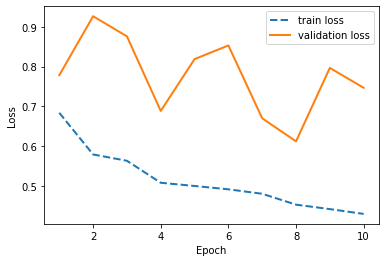

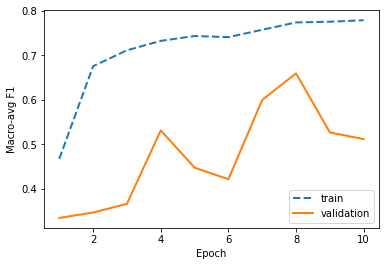

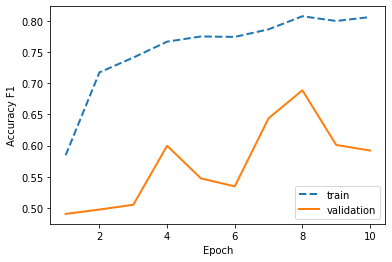

In [48]:
def save_plots(train_losses, val_losses, train_f1, val_f1, train_accs, val_accs):
    """Plot

        Plot two figures: loss vs. epoch and accuracy vs. epoch
    """
    n = len(train_losses)
    xs = np.arange(1,n+1,1)

    # plot train and val losses
    fig, ax = plt.subplots()
    ax.plot(xs, train_losses, '--', linewidth=2, label='train loss')
    ax.plot(xs, val_losses, '-', linewidth=2, label='validation loss')
    #ax.set_xlim(0, 10)
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.legend(loc='upper right')
    plt.savefig('data/bert_plot/loss_RoBerta_Twt_utype.png')

    # plot train and val f1-score
    #plt.clf()
    fig, ax = plt.subplots()
    ax.plot(xs, train_f1, '--', linewidth=2, label='train')
    ax.plot(xs, val_f1, '-', linewidth=2, label='validation')
    
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Macro-avg F1")
    ax.legend(loc='lower right')
    plt.savefig('data/bert_plot/f1_RoBerta_Twt_utype.png')
    
    # plot train and val accuracy
    #plt.clf()
    fig, ax = plt.subplots()
    ax.plot(xs, train_accs, '--', linewidth=2, label='train')
    ax.plot(xs, val_accs, '-', linewidth=2, label='validation')
    #ax.set_xlim(0, 10)
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Accuracy F1")
    ax.legend(loc='lower right')
    plt.savefig('data/bert_plot/acc_RoBerta_Twt_utype.png')
    
save_plots(per_epoch_train_loss, per_epoch_val_loss, per_epoch_train_f1, per_epoch_val_f1, per_epoch_train_acc, per_epoch_val_acc)

In [49]:
test_dataloader = DataLoader(
            test_dataset, # The validation samples.
            sampler = SequentialSampler(test_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [50]:
def evaluate_test(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    epoch_macro = 0
    model.eval()
    
    with torch.no_grad():
    
        #for batch in iterator:
        preds , true_labels = [], []
        for step, batch in enumerate(iterator):    
            text = batch[0].to(device)
            label = batch[1].to(device)

            #predictions = model(batch.text).squeeze(1)
            predictions = model(text)
            
            #loss = criterion(predictions, batch.label)
            loss = criterion(predictions, label)
            #acc = binary_accuracy(predictions, batch.label)
            acc, macro_f1 = binary_accuracy(torch.argmax(predictions, dim = 1), label)
            epoch_loss += loss.item()
            epoch_acc += acc.item()
            epoch_macro += macro_f1.item()
            
            # Store predictions and true labels
            preds.append(torch.argmax(predictions, dim = 1).to('cpu').numpy())
            true_labels.append(label.to('cpu').numpy())
            
                        
    return epoch_loss / len(iterator), epoch_acc / len(iterator), epoch_macro / len(iterator), preds, true_labels

In [51]:
from sklearn.metrics import classification_report

for epoch in range(0,10):
    model.load_state_dict(torch.load('data/bert_twt/model_long_roberta_utype'+str(epoch+1)+'.pt'))
    test_loss, test_acc, test_f1, pred, label = evaluate_test(model, test_dataloader, criterion)

    print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.3f} | Test macro-avg-f1: {test_f1*100:.3f}%')
    flat_predictions = np.concatenate(pred, axis=0)
    flat_labels = np.concatenate(label, axis=0)
    
    print(classification_report(flat_labels, flat_predictions, digits=4))

Test Loss: 0.528 | Test Acc: 77.750 | Test macro-avg-f1: 75.504%
              precision    recall  f1-score   support

           0     0.7696    0.7889    0.7792       199
           1     0.7812    0.7614    0.7712       197

    accuracy                         0.7753       396
   macro avg     0.7754    0.7752    0.7752       396
weighted avg     0.7754    0.7753    0.7752       396

Test Loss: 0.491 | Test Acc: 82.250 | Test macro-avg-f1: 80.541%
              precision    recall  f1-score   support

           0     0.7759    0.9045    0.8353       199
           1     0.8841    0.7360    0.8033       197

    accuracy                         0.8207       396
   macro avg     0.8300    0.8203    0.8193       396
weighted avg     0.8297    0.8207    0.8194       396

Test Loss: 0.487 | Test Acc: 78.500 | Test macro-avg-f1: 75.611%
              precision    recall  f1-score   support

           0     0.7839    0.7839    0.7839       199
           1     0.7817    0.7817    0.781

In [ ]:
# Test Loss: 0.502 | Test Acc: 76.50 | Test macro-avg-f1: 73.57%
# Test Loss: 0.540 | Test Acc: 81.00 | Test macro-avg-f1: 76.90%